In [2]:
pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/3e/cf/ede993ed7070c5487e6db550aad490178c06eaa48ad26ff5e5263f995fba/geopandas-0.14.1-py3-none-any.whl.metadata
  Using cached geopandas-0.14.1-py3-none-any.whl.metadata (1.5 kB)
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/79/95/eb68113c5b5737c342bde1bab92705dabe69c16299c5a122616e50f1fbd6/pyproj-3.6.1-cp311-cp311-win_amd64.whl.metadata
  Using cached pyproj-3.6.1-cp311-cp311-win_amd64.whl.metadata (31 kB)
Using cached geopandas-0.14.1-py3-none-any.whl (1.1 MB)
Using cached pyproj-3.6.1-cp311-cp311-win_amd64.whl (6.1 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
### Importation des modules
import pandas as pd
import geopandas as gpd
import re
import numpy as np
import csv
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import plotly.express as px

C:/Users/Cosima/Documents/Ensae/Statapp/Données/Trafic-en-Zone-a-Zone/Zoazo_depuis-1996.xlsx


In [3]:
def nettoyer_zoazo(chemin_acces_zoazo, chemin_acces_communes) :
    zoazo = pd.read_excel(chemin_acces_zoazo,
                          sheet_name=0,
                          usecols=['Année', 'Source', 'Traf_Qual', 'CA_Qual', 'zon1_lib', 'zon2_lib', 'zon1_cod', 'zon2_cod',
                                   'zon1_zon2', 'voy_1', 'voy_2', 'voy_tot', 'VK_1', 'VK_2', 'VK_tot', 'rechc_1', 'rechc_2',
                                   'rechc_tot', 'comp_1', 'comp_2'])

    ### Transformer les types de zoazo :

    zoazo['Année'] = zoazo['Année'].astype('int')
    zoazo['Année'] = pd.to_datetime(zoazo['Année'], format = '%Y')
    zoazo['Année'] = zoazo['Année'].dt.year
    zoazo['zon1_lib'] = zoazo['zon1_lib'].astype('string')
    zoazo['zon2_lib'] = zoazo['zon2_lib'].astype('string')
    zoazo['zon1_cod'] = zoazo['zon1_cod'].astype('string')
    zoazo['zon2_cod'] = zoazo['zon2_cod'].astype('string')
    zoazo['zon1_zon2'] = zoazo['zon1_zon2'].astype('string')

# Remplacer "Genève Bellegarde" par "Bellegarde"
    zoazo['zon1_lib'] = zoazo['zon1_lib'].replace('Genève Bellegarde', 'Bellegarde')

    # Remplacer "St Raphël" par "St Raphaël"
    zoazo['zon1_lib'] = zoazo['zon1_lib'].replace('St Raphël', 'St Raphaël')

      #Même chose pour zon2_lib
      # Remplacer "Genève Bellegarde" par "Bellegarde"
    zoazo['zon2_lib'] = zoazo['zon2_lib'].replace('Genève Bellegarde', 'Bellegarde')

      # Remplacer "St Raphël" par "St Raphaël"
    zoazo['zon2_lib'] = zoazo['zon2_lib'].replace('St Raphël', 'St Raphaël')

###Importation base communes :

# Utilisez la fonction read_csv de pandas pour lire le fichier CSV
    communes = pd.read_csv(chemin_acces_communes, encoding="UTF-8")

# Sélection des variables d'intérêt et renommer les colonnes
    communes = communes[['COM', 'REG', 'LIBELLE']]
    communes = communes.rename(columns={'COM': 'code_com1', 'REG': 'region1'})

# Filtrage des observations avec des valeurs manquantes dans la colonne region1
    communes = communes.dropna(subset=['region1'])

    communes['region1'] = communes['region1'].astype('int')

    communes['LIBELLE'] = communes['LIBELLE'].astype('string')
    communes['code_com1'] = communes['code_com1'].astype('string')
    communes['region1'] = communes['region1'].astype('string')


# Remplacer les tirets par des espaces et "Saint" par "St" dans la colonne LIBELLE
    communes['LIBELLE'] = communes['LIBELLE'].str.replace('-', ' ')
    communes['LIBELLE'] = communes['LIBELLE'].str.replace('-', ' ')  # Appliqué deux fois pour tous les tirets
    communes['LIBELLE'] = communes['LIBELLE'].str.replace('Saint', 'St')

    communes['dupli'] = communes['LIBELLE'].duplicated(keep='first')

# Selection des communes sans doublons
    communes = communes[~communes['dupli']]

# Suppression de la colonne 'dupli'
    communes = communes.drop(columns=['dupli'])

 # Ajout des bons codes communes pour les communes dont le libellé est en double (on n'a gardé que la prmière
  #occurence du libellé pour simplifier, mais le code associé ne correspond donc pas forcément à la bonne commune, ce qui
  #posera problème pour la représentation graphique)
    communes.loc[communes['LIBELLE'] == 'Bellegarde', 'code_com1'] = '01200'
    communes.loc[communes['LIBELLE'] == 'Chaumont', 'code_com1'] = '52121'
    communes.loc[communes['LIBELLE'] == 'La Rochelle', 'code_com1'] = '17300'
    communes.loc[communes['LIBELLE'] == 'Le Puy', 'code_com1'] = '43157'
    communes.loc[communes['LIBELLE'] == 'Moulins', 'code_com1'] = '03190'
    communes.loc[communes['LIBELLE'] == 'Moutiers', 'code_com1'] = '73181'
    communes.loc[communes['LIBELLE'] == 'St Gervais', 'code_com1'] = '74236'
    communes.loc[communes['LIBELLE'] == 'St Nazaire', 'code_com1'] = '44184'
    communes.loc[communes['LIBELLE'] == 'St Raphaël', 'code_com1'] = '83118'
    communes.loc[communes['LIBELLE'] == 'Valence', 'code_com1'] = '26362'

    # Fusion des deux tables par le libellé de la zone 1 (zon1_lib) et LIBELLE pour ajouter le code commune insee de la zone à zoazo
    zoazo = pd.merge(zoazo, communes, left_on='zon1_lib', right_on='LIBELLE', how='left')

    zoazo = zoazo.drop(columns=['LIBELLE'])

 #Même chose avec lib_zon2

      # On renomme les colonnes pour la zone 2 pour ajouter le code comm  et la région de la zone 2
    communes = communes.rename(columns={'region1': 'region2', 'code_com1': 'code_com2'})

    communes['LIBELLE'] = communes['LIBELLE'].astype('string')
    communes['code_com2'] = communes['code_com2'].astype('string')
    communes['region2'] = communes['region2'].astype('string')

  # Fusionnez par le libellé de la zone 2 (zon2_lib) et LIBELLE
    zoazo = pd.merge(zoazo, communes, left_on='zon2_lib', right_on='LIBELLE', how='left')

    zoazo = zoazo.drop(columns=['LIBELLE'])
 # Ajout des codes région et libellés région pour la zone 1
    zoazo.loc[zoazo['zon1_lib'] == 'Ile de France', 'region1'] = '11'
    zoazo.loc[zoazo['zon1_lib'] == 'Aix en Provence TGV', 'region1'] = '93'
    zoazo.loc[zoazo['zon1_lib'].isin(['Ambérieu', 'Lyon St Exupéry - Bourgoin', 'St Etienne']), 'region1'] = '84'
    zoazo.loc[zoazo['zon1_lib'].isin(['Brive', 'Chatellerault', 'Sablé', 'Saintes']), 'region1'] = '75'
    zoazo.loc[zoazo['zon1_lib'].isin(['Cherbourg', 'Evreux']), 'region1'] = '28'
    zoazo.loc[zoazo['zon1_lib'].isin(['La Baule', 'Sablé']), 'region1'] = '52'
    zoazo.loc[zoazo['zon1_lib'].isin(['Le Creusot TGV', 'Mâcon TGV']), 'region1'] = '27'
    zoazo.loc[zoazo['zon1_lib'] == 'Lens - Béthune', 'region1'] = '32'
    zoazo.loc[zoazo['zon1_lib'].isin(['Epinal', 'Epinal']), 'region1'] = '44'


      # Ajout des codes région et libellés région pour la zone 2
    zoazo.loc[zoazo['zon2_lib'] == 'Ile de France', 'region2'] = '11'
    zoazo.loc[zoazo['zon2_lib'] == 'Aix en Provence TGV', 'region2'] = '93'
    zoazo.loc[zoazo['zon2_lib'].isin(['Ambérieu', 'Lyon St Exupéry - Bourgoin', 'St Etienne']), 'region2'] = '84'
    zoazo.loc[zoazo['zon2_lib'].isin(['Brive', 'Chatellerault', 'Sablé', 'Saintes']), 'region2'] = '75'
    zoazo.loc[zoazo['zon2_lib'].isin(['Cherbourg', 'Evreux']), 'region2'] = '28'
    zoazo.loc[zoazo['zon2_lib'].isin(['La Baule', 'Sablé']), 'region2'] = '52'
    zoazo.loc[zoazo['zon2_lib'].isin(['Le Creusot TGV', 'Mâcon TGV']), 'region2'] = '27'
    zoazo.loc[zoazo['zon2_lib'] == 'Lens - Béthune', 'region2'] = '32'
    zoazo.loc[zoazo['zon2_lib'].isin(['Epinal', 'Epinal']), 'region2'] = '44'

    zoazo['region1_lib'] = zoazo['region1'].map({
          '11': 'Ile de France',
          '24': 'Centre Val de Loire',
          '27': 'Bourgogne Franche Comté',
          '28': 'Normandie',
          '32': 'Hauts de France',
          '44': 'Grand Est',
          '52': 'Pays de la Loire',
          '53': 'Bretagne',
          '75': 'Nouvelle Acquitaine',
          '76': 'Occitanie',
          '84': 'Auvergne Rhônes Alpes',
          '93': 'Provence Alpes Côte d\'Azur'
      })


      # Ajout des libellés région pour la zone 2
    zoazo['region2_lib'] = zoazo['region2'].map({
          '11': 'Ile de France',
          '24': 'Centre Val de Loire',
          '27': 'Bourgogne Franche Comté',
          '28': 'Normandie',
          '32': 'Hauts de France',
          '44': 'Grand Est',
          '52': 'Pays de la Loire',
          '53': 'Bretagne',
          '75': 'Nouvelle Acquitaine',
          '76': 'Occitanie',
          '84': 'Auvergne Rhônes Alpes',
          '93': 'Provence Alpes Côte d\'Azur'
      })

          ### Ajout des codes communes manquants
    # Définition des conditions et des valeurs pour code_com1


    zoazo.loc[zoazo['zon1_lib'] == 'Epinal', 'code_com1'] = '88160'
    zoazo.loc[zoazo['zon1_lib'] == 'Lens - Béthune', 'code_com1'] = '62498'
    zoazo.loc[zoazo['zon1_lib'] == 'La Baule', 'code_com1'] = '44055'
    zoazo.loc[zoazo['zon1_lib'] == 'Sablé', 'code_com1'] = '72264'
    zoazo.loc[zoazo['zon1_lib'] == 'Evreux', 'code_com1'] = '27229'
    zoazo.loc[zoazo['zon1_lib'] == 'Cherbourg', 'code_com1'] = '50129'
    zoazo.loc[zoazo['zon1_lib'] == 'Saintes', 'code_com1'] = '17425'
    zoazo.loc[zoazo['zon1_lib'] == 'Ambérieu', 'code_com1'] = '01004'
    zoazo.loc[zoazo['zon1_lib'] == 'Brive', 'code_com1'] = '19031'
    zoazo.loc[zoazo['zon1_lib'] == 'Aix en Provence TGV', 'code_com1'] = '13001'
    zoazo.loc[zoazo['zon1_lib'] == 'Chatellerault', 'code_com1'] = '86066'
    zoazo.loc[zoazo['zon1_lib'] == 'Lyon St Exupéry - Bourgoin', 'code_com1'] = '38053'
    zoazo.loc[zoazo['zon1_lib'] == 'St Etienne', 'code_com1'] = '42218'
    zoazo.loc[zoazo['zon1_lib'] == 'Le Creusot TGV', 'code_com1'] = '71153'
    zoazo.loc[zoazo['zon1_lib'] == 'Mâcon TGV', 'code_com1'] = '71270'

      # Ajout des codes communes manquants pour la zone 2
    zoazo.loc[zoazo['zon2_lib'] == 'Epinal', 'code_com2'] = '88160'
    zoazo.loc[zoazo['zon2_lib'] == 'Lens - Béthune', 'code_com2'] = '62498'
    zoazo.loc[zoazo['zon2_lib'] == 'La Baule', 'code_com2'] = '44055'
    zoazo.loc[zoazo['zon2_lib'] == 'Sablé', 'code_com2'] = '72264'
    zoazo.loc[zoazo['zon2_lib'] == 'Evreux', 'code_com2'] = '27229'
    zoazo.loc[zoazo['zon2_lib'] == 'Cherbourg', 'code_com2'] = '50129'
    zoazo.loc[zoazo['zon2_lib'] == 'Saintes', 'code_com2'] = '17425'
    zoazo.loc[zoazo['zon2_lib'] == 'Ambérieu', 'code_com2'] = '01004'
    zoazo.loc[zoazo['zon2_lib'] == 'Brive', 'code_com2'] = '19031'
    zoazo.loc[zoazo['zon2_lib'] == 'Aix en Provence TGV', 'code_com2'] = '13001'
    zoazo.loc[zoazo['zon2_lib'] == 'Chatellerault', 'code_com2'] = '86066'
    zoazo.loc[zoazo['zon2_lib'] == 'Lyon St Exupéry - Bourgoin', 'code_com2'] = '38053'
    zoazo.loc[zoazo['zon2_lib'] == 'St Etienne', 'code_com2'] = '42218'
    zoazo.loc[zoazo['zon2_lib'] == 'Le Creusot TGV', 'code_com2'] = '71153'
    zoazo.loc[zoazo['zon2_lib'] == 'Mâcon TGV', 'code_com2'] = '71270'


    return(zoazo)








In [4]:
#zoazo = nettoyer_zoazo(chemin_acces_zoazo=chemin_zoazo, chemin_acces_communes=chemin_communes)

In [6]:
#zoazo.head()

,Année,Source,Traf_Qual,CA_Qual,zon1_lib,zon2_lib,zon1_cod,zon2_cod,zon1_zon2,voy_1,...,rechc_2,rechc_tot,comp_1,comp_2,code_com1,region1,code_com2,region2,region1_lib,region2_lib
0,1996,Aristote-Opale,Détail C1-C2,Détail C1-C2,Ile de France,Ile de France,10,10,10 - 10,59765.0,...,1.051001e+07,1.116733e+07,34049.792898,2.209081e+06,<NA>,11,<NA>,11,Ile de France,Ile de France
1,1996,Aristote-Opale,Détail C1-C2,Détail C1-C2,Ile de France,Vesoul,10,121,10 - 121,22438.0,...,2.329916e+06,3.110547e+06,71084.385105,2.415684e+05,<NA>,11,70550,27,Ile de France,Bourgogne Franche Comté
2,1996,Aristote-Opale,Détail C1-C2,Détail C1-C2,Ile de France,Bar le Duc,10,130,10 - 130,26127.0,...,2.242249e+06,2.995750e+06,71137.284913,3.632262e+05,<NA>,11,55029,44,Ile de France,Grand Est
3,1996,Aristote-Opale,Détail C1-C2,Détail C1-C2,Ile de France,Nancy,10,133,10 - 133,226659.0,...,1.235518e+07,2.123667e+07,283714.938632,9.983170e+05,<NA>,11,54395,44,Ile de France,Grand Est
4,1996,Aristote-Opale,Détail C1-C2,Détail C1-C2,Ile de France,Epinal,10,137,10 - 137,31936.0,...,3.759424e+06,5.107679e+06,94219.133266,5.715887e+05,<NA>,11,88160,44,Ile de France,Grand Est


In [7]:
#zoazo.loc[zoazo['code_com1'].isna(), 'zon1_lib'].drop_duplicates()


0    Ile de France
Name: zon1_lib, dtype: string

In [41]:
#zoazo.loc[~zoazo['code_com1'].isna(), 'zon1_lib'].drop_duplicates()

146                   Vesoul
291               Bar le Duc
435                    Nancy
578                   Epinal
720                    Reims
                ...         
10721                 Millau
10725            Carcassonne
10728         Le Creusot TGV
10730              Mâcon TGV
64005    Aix en Provence TGV
Name: zon1_lib, Length: 146, dtype: string

In [13]:
### Fonction pour importer le contours des régions

def importer_contours_regions(chemin_contours_regions):
    # Importation des périmètres des régions
    regions = gpd.read_file(chemin_contours_regions)

    # Conversion du système de projection en Lambert 93 (code EPSG 2154)
    regions = regions.to_crs(epsg=2154)

    # Sélectionner le code région et la géométrie
    regions = regions[['code_insee', 'geometry']]

    # Retirer les régions d'Outre-mer car pas dans le champ (pas la SNCF)
    regions = regions[~regions['code_insee'].str.contains('0')]

    # Retirer la Corse 
    regions = regions[regions['code_insee'] != '94']

    return regions




EPSG:2154
  code_insee                                           geometry
3         11  POLYGON ((586417.780 6884063.864, 586655.116 6...
4         32  MULTIPOLYGON (((583889.201 6997502.901, 583901...
5         75  MULTIPOLYGON (((311740.213 6264425.418, 311800...
6         28  MULTIPOLYGON (((343118.952 6968683.192, 343149...
8         52  MULTIPOLYGON (((280814.609 6711870.447, 280834...


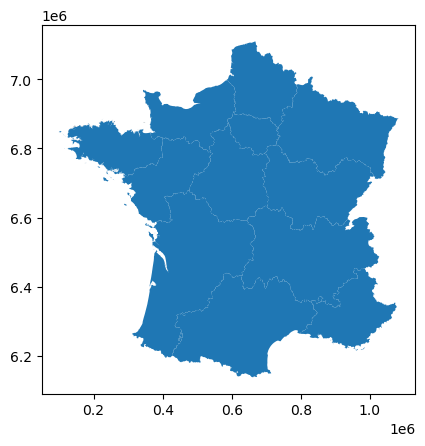

In [11]:


# Importation des périmètres des régions
#regions = gpd.read_file("C:/Users/Cosima/Documents/Ensae/Statapp/Données/regions-20180101-shp")

# Conversion du système de projection en Lambert 93 (code EPSG 2154)
#regions = regions.to_crs(epsg=2154)

# Afficher à nouveau les informations après la transformation
#regions.head()
#print(regions.crs)

# Sélectionner le code région et la géométrie
#regions = regions[['code_insee', 'geometry']]

# Filtrer les régions d'outre-mer
#regions = regions[~regions['code_insee'].str.contains('0')]

# Retirer la Corse
#regions = regions[regions['code_insee'] != '94']

# Afficher les informations sur le GeoDataFrame après la transformation
#print(regions.head())

# Plot avec matplotlib
#regions.plot()
#plt.show()



Importation des périmètres des communes françaises

In [14]:
### Fonction pour importer le contours des communes françaises


def importer_contours_communes(chemin_contours_communes) :
    contours_communes = gpd.read_file(chemin_contours_communes)

# Conversion du système de projection en Lambert 93 (code EPSG 2154)
    contours_communes = contours_communes.to_crs(epsg=2154)

#Sélection des varianles 'code_insee' equivalent au code commune de la base zoazo, et geometry
    contours_communes = contours_communes[['insee', 'geometry']]

#Variable 'insee' renommée en 'code_insee'
    contours_communes = contours_communes.rename(columns={'insee': 'code_insee'}) #vieux nom = nv nom

    return contours_communes

Nettoyage de la base remplissage 

In [2]:
def nettoyer_base_remplissage(chemin_acces_remplissage, chemin_acces_codes_gares) :
    #Importation de la base
    seg_charge = pd.read_csv(chemin_acces_remplissage, usecols=['ENTITE', 'DPT_DATE', 'TRAIN', 'ORIG', 'DEST',
       'LEG_ORIG', 'LEG_DEST', 'TRANCHE', 'HEURE', 'HEURE_ARR', 'NIVEAU',
       'peak', 'AUTOA0', 'AUTOB0', 'J_A', 'J_B', 'REC_A', 'REC_B', 'RECETTE',
       'CAP_A', 'CAP_B', 'TRAF_A', 'TRAF_B', 'resa_A', 'resa_B', 'Nature',
       'TOP'])
    seg_charge = seg_charge[~seg_charge['ORIG'].isna()] #3 lignes totalement NA qu'on enlève de la base



    #Conversion des types de données
    seg_charge['ORIG'] = seg_charge['ORIG'].astype('string')
    seg_charge['LEG_ORIG'] = seg_charge['LEG_ORIG'].astype('string')
    seg_charge['DEST'] = seg_charge['DEST'].astype('string')
    seg_charge['LEG_DEST'] = seg_charge['LEG_DEST'].astype('string')
    seg_charge['ENTITE'] = seg_charge['ENTITE'].astype('string')
    seg_charge['peak'] = seg_charge['peak'].astype('string')
    seg_charge['J_A'] = seg_charge['J_A'].fillna(10000)
    seg_charge['J_A'] = seg_charge['J_A'].replace('.', 10000)
    seg_charge['J_A'] = seg_charge['J_A'].astype('int')
    seg_charge['J_A'] = seg_charge['J_A'].abs()
    seg_charge['J_B'] = seg_charge['J_B'].fillna(10000)
    seg_charge['J_B'] = seg_charge['J_B'].replace('.', 10000)
    seg_charge['J_B'] = seg_charge['J_B'].astype('int')
    seg_charge['J_B'] = seg_charge['J_B'].abs()
    seg_charge['DPT_DATE'] = pd.to_datetime(seg_charge['DPT_DATE'], format= '%d/%m/%Y %H:%M:%S') #Conversion de la date de départ en type date

    #Ajout variable code du segment qui permet de regarder un segment spécifique
    seg_charge['code_seg'] = seg_charge['LEG_ORIG'] + '-' + seg_charge['LEG_DEST']

    #Ajout du libellé des gares via le fichier codesgare
    code_gare = pd.read_excel(chemin_acces_codes_gares)

    #Ajout lib gare d'origine
    code_orig = code_gare[['IATA', 'Libellé gare', 'Dépt']] #On sélectionne les variables 'IATA', Libellé gare et dept
    code_orig = code_orig.rename(columns={'IATA' : 'ORIG'}) #Variable IATA correspond au code la gare de départ
    code_orig = code_orig.rename(columns={'Libellé gare' : 'LIB_ORIG'})
    code_orig = code_orig.rename(columns={'Dépt' : 'DEPT_ORIG'})
    
    #Ajout libelle gare de départ
    seg_charge = seg_charge = pd.merge(seg_charge, code_orig, on='ORIG', how='left')

    #On renomme colonnes de la table code_orig en variables indiquant la destination

    code_orig = code_orig.rename(columns={'ORIG' : 'DEST'}) #Variable IATA correspond au code la gare de départ
    code_orig = code_orig.rename(columns={'LIB_ORIG' : 'LIB_DEST'})
    code_orig = code_orig.rename(columns={'DEPT_ORIG' : 'DEPT_DEST'})

    #Ajout libelle gare de départ
    seg_charge = seg_charge = pd.merge(seg_charge, code_orig, on='DEST', how='left')

    #Ajout du libellé de la gare d'origine du segment le plus chargé
    code_orig = code_orig[['DEST', 'LIB_DEST']]
    code_orig = code_orig.rename(columns={'DEST' : 'LEG_ORIG'}) #Variable IATA correspond au code la gare de départ
    code_orig = code_orig.rename(columns={'LIB_DEST' : 'LIB_LEG_ORIG'})

    seg_charge = seg_charge = pd.merge(seg_charge, code_orig, on='LEG_ORIG', how='left') #merge avec seg_charge
    
    #Ajout de libellé de la destination du segment le plus chargé
    code_orig = code_orig.rename(columns={'LEG_ORIG' : 'LEG_DEST'}) #Variable IATA correspond au code la gare de départ
    code_orig = code_orig.rename(columns={'LIB_LEG_ORIG' : 'LIB_LEG_DEST'})

    seg_charge = seg_charge = pd.merge(seg_charge, code_orig, on='LEG_DEST', how='left')

    seg_charge['lib_seg'] = seg_charge['LIB_LEG_ORIG'] + '-' + seg_charge['LIB_LEG_DEST']

    #Ajout d'une colonne année
    seg_charge['annee'] = seg_charge['DPT_DATE'].dt.year

    #Ajout d'une colonne mois
    seg_charge['mois'] = seg_charge['DPT_DATE'].dt.month

    return(seg_charge)
    
    #Convertir la variable 'J_A' en valeur absolue




